In [1]:
# autoreload
%load_ext autoreload
%autoreload 2

In [2]:
import jax
import jax.numpy as jnp
from jax import random
from functools import partial
from typing import Optional, Mapping, Tuple, Sequence, Union, Any, Callable, Iterator
from jaxtyping import Array, PRNGKeyArray
from generax.training.trainer import Trainer
import generax.nn.util as util
import matplotlib.pyplot as plt

### Get our dataset

In [3]:
# Get the dataset
from sklearn.datasets import make_moons, make_swiss_roll
data, y = make_moons(n_samples=100000, noise=0.1)
data = data - data.mean(axis=0)
data = data/data.std(axis=0)
key = random.PRNGKey(0)

def get_train_ds(key: PRNGKeyArray,
                 batch_size: int = 64) -> Iterator[Mapping[str, Array]]:
  total_choices = jnp.arange(data.shape[0])
  closed_over_data = data # In case we change the variable "data"
  while True:
    key, _ = random.split(key, 2)
    idx = random.choice(key,
                        total_choices,
                        shape=(batch_size,),
                        replace=True)
    yield dict(x=closed_over_data[idx])

train_ds = get_train_ds(key)


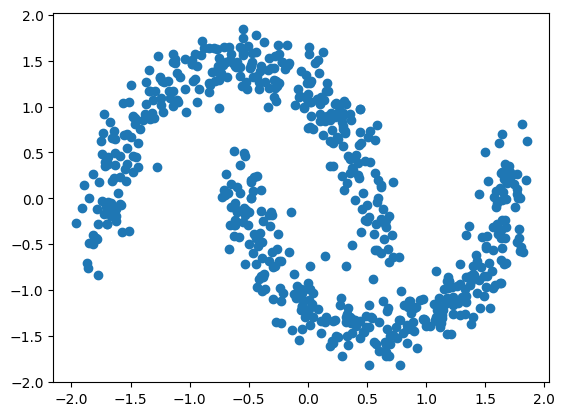

In [4]:
true_samples = util.extract_multiple_batches_from_iterator(train_ds,
                                                   n_batches=10,
                                                   single_batch=True)
plt.scatter(*true_samples['x'].T)


## Build our flow

In [5]:
x = data[:10]

from generax.distributions.flow_models import RealNVP, NeuralSpline, ContinuousNormalizingFlow

P = NeuralSpline(input_shape=x.shape[1:],
                  key=key,
                  n_flow_layers=3,
                  n_blocks=4,
                  hidden_size=32,
                  working_size=16,
                  n_spline_knots=8)

# P = ContinuousNormalizingFlow(input_shape=x.shape[1:],
#            key=key,
#            n_blocks=4,
#            hidden_size=32,
#            working_size=16,
#            time_embedding_size=8,
#            n_time_features=4,
#            trace_estimate_likelihood=True)

## Train the flow

In [6]:
from generax.training import max_likelihood
import optax

# Create the optimizer
schedule = optax.warmup_cosine_decay_schedule(init_value=0.0,
                                   peak_value=1.0,
                                   warmup_steps=1000,
                                   decay_steps=3e5,
                                   end_value=0.1,
                                   exponent=1.0)
chain = []
chain.append(optax.clip_by_global_norm(15.0))
chain.append(optax.adamw(5e-4))
chain.append(optax.scale_by_schedule(schedule))
optimizer = optax.chain(*chain)

# Create the trainer
trainer = Trainer(checkpoint_path='tmp/flow/NeuralSplines')
model = trainer.train(model=P,
                      objective=max_likelihood,
                      evaluate_model=lambda x: x,
                      optimizer=optimizer,
                      num_steps=10000,
                      double_batch=1000,
                      data_iterator=train_ds,
                      checkpoint_every=1000,
                      test_every=-1,
                      retrain=True)

loss: 2.3085:  20%|██        | 2000/10000 [00:28<01:52, 71.20it/s]

Checkpointed model


loss: 2.1652:  30%|███       | 3000/10000 [00:29<00:58, 119.42it/s]

Checkpointed model


loss: 2.0874:  40%|████      | 4000/10000 [00:31<00:34, 176.27it/s]

Checkpointed model


loss: 2.0609:  50%|█████     | 5000/10000 [00:32<00:21, 237.70it/s]

Checkpointed model


loss: 2.0400:  60%|██████    | 6000/10000 [00:34<00:13, 302.37it/s]

Checkpointed model


loss: 2.0204:  70%|███████   | 7000/10000 [00:36<00:08, 364.58it/s]

Checkpointed model


loss: 1.9935:  80%|████████  | 8000/10000 [00:37<00:04, 422.30it/s]

Checkpointed model


loss: 1.9758:  90%|█████████ | 9000/10000 [00:39<00:02, 469.23it/s]

Checkpointed model


loss: 1.9497:   0%|          | 10/10000 [00:40<11:20:43,  4.09s/it] 

Checkpointed model


In [7]:
samples = model.sample(key, n_samples=1000)

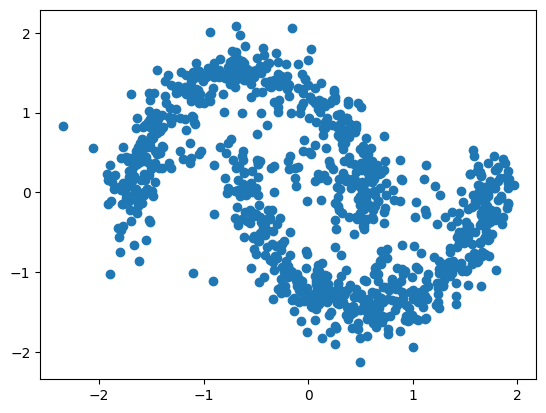

In [8]:
import matplotlib.pyplot as plt
plt.scatter(*samples.T)